In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-08-29 16:36:00.366875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2
1 Physical GPUs, 1 Logical GPUs


2025-08-29 16:36:03.659982: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-29 16:36:05.497859: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-29 16:36:05.497912: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-29 16:36:05.498855: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-29 16:36:05.498924: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [121]:
# clean for debug purpose only 

trainData = None
valData = None
testData = None

for layer in model.layers:
	if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'kernel'):
		layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape, dtype=layer.kernel.dtype))
	if hasattr(layer, 'bias_initializer') and hasattr(layer, 'bias'):
		layer.bias.assign(layer.bias_initializer(layer.bias.shape, dtype=layer.bias.dtype))

tf.keras.backend.clear_session(free_memory=True)


2025-08-29 16:15:30.591026: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Loading the data

Since there were multiple labels, I decided to write a custom import for the images and labels.

The custom import allowed me to load and identify the class imbalances of the dataset. 

In [2]:
# load images and labels 
from collections import Counter
import csv

imageFileNames = tf.data.Dataset.list_files('./images/*', shuffle=False)

allLabelDict = {}

numTrainImages = 0
labelDict = Counter()
cellShapeDict = Counter()
nucleusShapeDict = Counter()
cytoplasmVacuoleDict = Counter()

# loads the labels from the csv 
with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		numTrainImages += 1
		labelDict[imgLabel['label']] += 1
		cellShapeDict[imgLabel['cell_shape']] += 1
		nucleusShapeDict[imgLabel['nucleus_shape']] += 1
		cytoplasmVacuoleDict[imgLabel['cytoplasm_vacuole']] += 1

	labelTuple = tuple(labelDict.keys())
	cellShapeTuple = tuple(cellShapeDict.keys())
	nucleusShapeTuple = tuple(nucleusShapeDict.keys())
	cytoplasmVacuoleTuple = tuple(cytoplasmVacuoleDict.keys())
	
	for imgLabel in csvItems:
		allLabelDict[imgLabel['imageID']] = [
			labelTuple.index(imgLabel['label']), 
			cellShapeTuple.index(imgLabel['cell_shape']), 
			nucleusShapeTuple.index(imgLabel['nucleus_shape']), 
			cytoplasmVacuoleTuple.index(imgLabel['cytoplasm_vacuole'])
		]

# A weighting for the classes to help prevent over fitting to over represented classes 
classWeightsRaw = {
	'label': {key: (labelDict[key] / numTrainImages) for key in labelTuple},
	'cellShape': {key: (cellShapeDict[key] / numTrainImages) for key in cellShapeTuple},
	'nucleusShape': {key: (nucleusShapeDict[key] / numTrainImages) for key in nucleusShapeTuple},
	'cytoplasmVacuole': {key: (cytoplasmVacuoleDict[key] / numTrainImages) for key in cytoplasmVacuoleTuple}
}

classWeights = {key: np.array([weight**-1 for weight in weights.values()]) for key, weights in classWeightsRaw.items()} 

# Estimate the accuracy of a model maKing random guesses  
classRandomAcc = {
	'label': sum([(i / numTrainImages)**2 for i in labelDict.values()]),
	'cellShape': sum([(i / numTrainImages)**2 for i in cellShapeDict.values()]),
	'nucleusShape': sum([(i / numTrainImages)**2 for i in nucleusShapeDict.values()]),
	'cytoplasmVacuole': sum([(i / numTrainImages)**2 for i in cytoplasmVacuoleDict.values()])
}

print(f'label class imbalance in %: {classWeightsRaw["label"]} | target % {1 / len(labelDict)}')
print(f'label class weights: {classWeights["label"]} | random guess accuracy {classRandomAcc["label"]}')
print(f'cell shape class imbalance in %: {classWeightsRaw["cellShape"]} | target % {100 / len(cellShapeDict)}')
print(f'cell shape class weights: {classWeights["cellShape"]} | random guess accuracy {classRandomAcc["cellShape"]}')
print(f'nucleus shape class imbalance in %: {classWeightsRaw["nucleusShape"]} | target % {100 / len(nucleusShapeDict)}')
print(f'nucleus shape class weights: {classWeights["nucleusShape"]} | random guess accuracy {classRandomAcc["nucleusShape"]}')
print(f'cytoplasm vacuole class imbalance in %: {classWeightsRaw["cytoplasmVacuole"]} | target % {100 / len(cytoplasmVacuoleDict)}')
print(f'cytoplasm vacuole class weights: {classWeights["cytoplasmVacuole"]} | random guess accuracy {classRandomAcc["cytoplasmVacuole"]}')


label class imbalance in %: {'Lymphocyte': 0.1158, 'Monocyte': 0.1358, 'Basophil': 0.1256, 'Neutrophil': 0.322, 'Eosinophil': 0.3008} | target % 0.2
label class weights: [8.63557858 7.36377025 7.96178344 3.10559006 3.32446809] | random guess accuracy 0.24179128
cell shape class imbalance in %: {'round': 0.7808, 'irregular': 0.2192} | target % 50.0
cell shape class weights: [1.2807377 4.5620438] | random guess accuracy 0.65769728
nucleus shape class imbalance in %: {'unsegmented-round': 0.1032, 'unsegmented-indented': 0.1298, 'irregular': 0.0858, 'segmented-multilobed': 0.1252, 'unsegmented-band': 0.258, 'segmented-bilobed': 0.298} | target % 16.666666666666668
nucleus shape class weights: [ 9.68992248  7.70416025 11.65501166  7.98722045  3.87596899  3.3557047 ] | random guess accuracy 0.20590296
cytoplasm vacuole class imbalance in %: {'no': 0.9278, 'yes': 0.0722} | target % 50.0
cytoplasm vacuole class weights: [ 1.0778185  13.85041551] | random guess accuracy 0.8660256799999999


## Creating the tensorflow dataset

Now that I had the data I needed to create the tensorflow dataset that supports multiple labels because the model will need to classify multiple classes.

I used the map function on the image files already imported to load the Images into [360, 360, 3] tensors and then I added the labels generated above. 

The labels needed to be in the form of a dict for the loss function to read them correctly but `py_function` only returns tensors so I had to add an extra function to convert the labels again. 

To improve the training I added some basic data augmentation that randomizes the orientation of the images used for training. 
I chose to only change the orientation because other factors liKe brightness and contrast was fairly consistent across the whole dataset due to the fact that the cell imaging machine produced fairly uniform brightness images.      

In [ ]:
def getLabel(path):
	path = path.numpy().decode("utf-8")
	Key = os.path.basename(path)[:9]
	
	if Key not in allLabelDict:
		print("Missing Key:", Key)
		raise ValueError("Missing label Key.")
	return tf.convert_to_tensor(allLabelDict[Key])

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_jpeg(img, channels=3)
	return tf.image.resize_with_crop_or_pad(img, 360, 360)

def processData(file_path):
	label = tf.py_function(func=getLabel, inp=[file_path], Tout=tf.int32)
	label.set_shape([4])

	img = tf.py_function(func=getImage, inp=[file_path], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label

def labelsToDict(img, label):
	labelDict = {
		"labelOutput": tf.convert_to_tensor([label[0]]),
    "cellShapeOutput": tf.convert_to_tensor([label[1]]),
    "nucleusShapeOutput": tf.convert_to_tensor([label[2]]),
    "cytoplasmVacuoleOutput": tf.convert_to_tensor([label[3]])
	}

	return img, labelDict

def augmentFn(img):
	img = tf.image.random_flip_left_right(img)
	img = tf.image.random_flip_left_right(img)
	return img

def augment(img, label):
	img.set_shape([360, 360, 3])
	img = tf.py_function(func=augmentFn, inp=[img], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label


valSize = int(numTrainImages * 0.3)
batchSize = 10

trainData = imageFileNames \
  .skip(valSize) \
	.take(numTrainImages - valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 
	
valData = imageFileNames \
  .take(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 

testData = imageFileNames \
	.skip(numTrainImages) \
	.map(getImage, num_parallel_calls=tf.data.AUTOTUNE) \
	.batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 

print(f"train data size {tf.data.experimental.cardinality(trainData).numpy() * batchSize}")
print(f"val data size {tf.data.experimental.cardinality(valData).numpy() * batchSize}")
print(f"test data size {tf.data.experimental.cardinality(testData).numpy() * batchSize}")


train data size 3500
val data size 1500
test data size 5300


## The model 

I chose to use the convocational layers from VGG16 as a base and then I started by adding a standard pooling layer followed by a 64 wide dense layer.
The model had to classify 4 different labels so I needed 4 different output layers label, cell shape, nucleus shape and cytoplasm vacuole. 


In [4]:
# input and rescale
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))
inputRescale = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputLayer)

# imagenet pre made model
baseModel = tf.keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(360, 360, 3),
    include_top=False
)
baseModel.trainable = False
convoLayers = baseModel(inputRescale, training=False)

# shared model layers
baseLayers = tf.keras.layers.MaxPooling2D()(convoLayers)
baseLayers = tf.keras.layers.Flatten()(baseLayers)
baseLayers = tf.keras.layers.Dense(64, activation='relu')(baseLayers)

#label 
labelOutput = tf.keras.layers.Dense(len(labelTuple), activation='softmax', name='labelOutput')(baseLayers)

# cell shape
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), activation='softmax', name='cellShapeOutput')(baseLayers)

# nucleus shape
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), activation='softmax', name='nucleusShapeOutput')(baseLayers)

# cytoplasm vacuole
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), activation='softmax', name='cytoplasmVacuoleOutput')(baseLayers)

## Compiling the model 

To add weighting and account for the imbalanced classes I created a simple custom loss function to that takes the output from `SparseCategoricalCrossentropy` and multiplies it by the class weights we generated while loading the data.



In [11]:
model = tf.keras.Model(
	name='multi-task-classifier',
	inputs=inputLayer, 
	outputs={
		'labelOutput': labelOutput,
		'cellShapeOutput': cellShapeOutput,
		'nucleusShapeOutput': nucleusShapeOutput,
		'cytoplasmVacuoleOutput': cytoplasmVacuoleOutput,
		}
)

def customAccuracyGenerator(classIndex: int):
	def classAccuracy(y_true, y_pred):
		y_true = tf.reshape(y_true, [-1])
		y_true = tf.cast(y_true, tf.int8)

		y_pred = tf.argmax(y_pred, 1)
		y_pred = tf.cast(y_pred, tf.int8)

		classMask = tf.constant([classIndex for i in range(batchSize)], dtype=tf.int8)
		
		maskComparison = tf.math.equal(y_true, classMask)
		comparison = tf.math.logical_and(tf.math.equal(y_true, y_pred), maskComparison)
		
		return tf.math.divide_no_nan(tf.math.count_nonzero(comparison), tf.math.count_nonzero(maskComparison))
	
	return classAccuracy

def customLossGenerator(weights):
	lossFn = tf.keras.losses.SparseCategoricalCrossentropy()
	return lambda y_true, y_pred: weights[tf.get_static_value(y_true)] * lossFn(y_true, y_pred)

model.compile(
  optimizer='adam',
  loss={
		'labelOutput': customLossGenerator(classWeights['label']),
		'cellShapeOutput': customLossGenerator(classWeights['cellShape']),
		'nucleusShapeOutput': customLossGenerator(classWeights['nucleusShape']),
		'cytoplasmVacuoleOutput': customLossGenerator(classWeights['cytoplasmVacuole'])
	},
  metrics={
		'labelOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(labelTuple))],
		'cellShapeOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(cellShapeTuple))],
		'nucleusShapeOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(nucleusShapeTuple))],
		'cytoplasmVacuoleOutput': ['accuracy'] + [customAccuracyGenerator(i) for i in range(len(cytoplasmVacuoleTuple))]
	},
)

model.summary()

Model: "multi-task-classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 360, 360,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 11, 11,    │ 14,714,688 │ rescaling[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 5, 5, 512) │          0 │ vgg16[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    819,264 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cellShapeOutput     │ (None, 2)         │        130 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cytoplasmVacuoleOu… │ (None, 2)         │        130 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labelOutput (Dense) │ (None, 5)         │        325 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nucleusShapeOutput  │ (None, 6)         │        390 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,534,927 (59.26 MB)

 Trainable params: 820,239 (3.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
history = model.fit(
  trainData,
  validation_data=valData,
  epochs=8,
  batch_size=batchSize
)


Epoch 1/8
350/350 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - cellShapeOutput_accuracy: 0.7929 - cellShapeOutput_class_accuracy: 0.9019 - cellShapeOutput_class_accuracy_1: 0.3922 - cellShapeOutput_loss: 1.1572 - cytoplasmVacuoleOutput_accuracy: 0.9503 - cytoplasmVacuoleOutput_class_accuracy: 0.9823 - cytoplasmVacuoleOutput_class_accuracy_1: 0.2643 - cytoplasmVacuoleOutput_loss: 1.0778 - labelOutput_accuracy: 0.9300 - labelOutput_class_accuracy: 0.6523 - labelOutput_class_accuracy_1: 0.6901 - labelOutput_class_accuracy_2: 0.6595 - labelOutput_class_accuracy_3: 0.9259 - labelOutput_class_accuracy_4: 0.9150 - labelOutput_loss: 1.3831 - loss: 10.0532 - nucleusShapeOutput_accuracy: 0.6649 - nucleusShapeOutput_class_accuracy: 0.5637 - nucleusShapeOutput_class_accuracy_1: 0.5626 - nucleusShapeOutput_class_accuracy_2: 0.2821 - nucleusShapeOutput_class_accuracy_3: 0.2085 - nucleusShapeOutput_class_accuracy_4: 0.7374 - nucleusShapeOutput_class_accuracy_5: 0.6631 - nucleusShapeOutput_loss: 6.4351 - val_

In [22]:
targetMetricTrain = 0
targetMetricVal = 0
totalWeights = 0

for key, weights in classWeightsRaw.items():
	for i in range(len(weights)):
		index = '' if i == 0 else f'_{i}'
		historyKey = f'{key}Output_class_accuracy{index}'

		inverseWeight = list(weights.values())[i] ** -1
		totalWeights += inverseWeight
		
		targetMetricTrain += history.history[historyKey][-1] * inverseWeight
		targetMetricVal += history.history[f'val_{historyKey}'][-1] * inverseWeight


print(f'Total classes: {totalWeights}')
print(f'Average accuracy train: {targetMetricTrain / totalWeights}')
print(f'Average accuracy val: {targetMetricVal / totalWeights}')


Total classes: 95.43019444889508
Average accuracy train: 0.6297850231033296
Average accuracy val: 0.4964535676492106


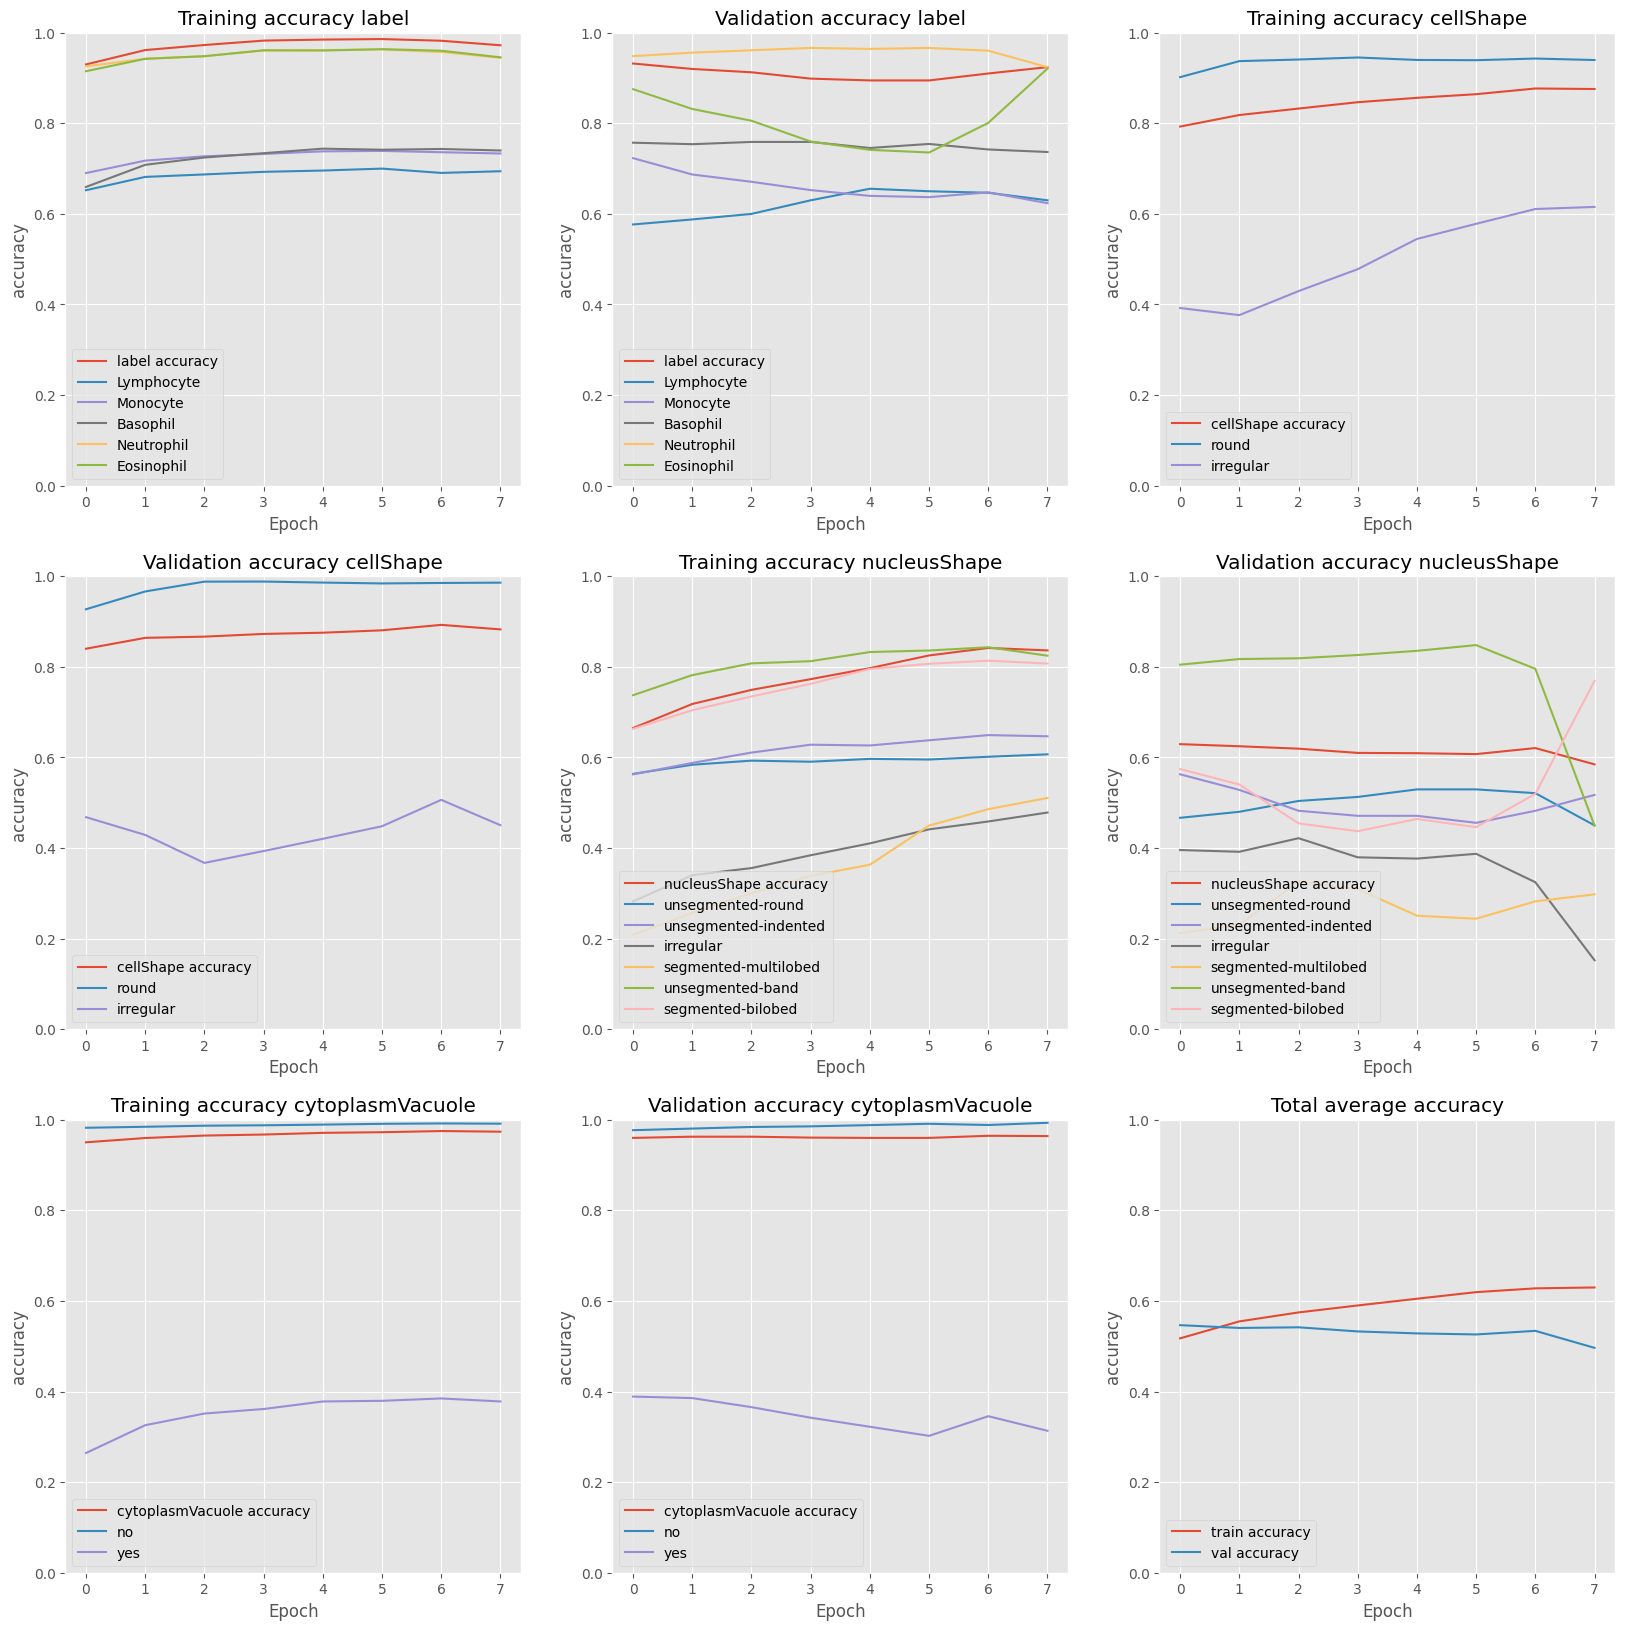

In [24]:
# Evaluation

plt.style.use("ggplot")
plt.figure(figsize=(20,20))
Nepoch=len(history.epoch)

targetMetricTrain = [0 for i in range(Nepoch)]
targetMetricVal = [0 for i in range(Nepoch)]
totalClasses = 0
totalWeights = 0

plotPos = 1
for outputType, outputClassWeights in classWeightsRaw.items(): 
	outputClassNames = list(outputClassWeights.keys())

	totalClasses += len(outputClassWeights)
	for i in range(len(outputClassWeights)):
		index = '' if i == 0 else f'_{i}'
		historyKey = f'{outputType}Output_class_accuracy{index}'
		
		inverseWeight = list(outputClassWeights.values())[i] ** -1
		totalWeights += inverseWeight

		for j in range(Nepoch):
			targetMetricTrain[j] += history.history[historyKey][j] *  inverseWeight
			targetMetricVal[j] += history.history[f'val_{historyKey}'][j] * inverseWeight

	plt.subplot(3,3,plotPos)
	plotPos += 1
	plt.plot(np.arange(0, Nepoch), history.history[f'{outputType}Output_accuracy'], label=f'{outputType} accuracy')

	for i in range(len(outputClassWeights)):
		index = '' if i == 0 else f'_{i}'
		key = f'{outputType}Output_class_accuracy{index}'
		
		plt.plot(np.arange(0, Nepoch), history.history[key], label=outputClassNames[i])

	plt.title(f"Training accuracy {outputType}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")

	plt.subplot(3,3,plotPos)
	plotPos += 1
	plt.plot(np.arange(0, Nepoch), history.history[f'val_{outputType}Output_accuracy'], label=f'{outputType} accuracy')

	for i in range(len(outputClassWeights)):
		index = '' if i == 0 else f'_{i}'
		key = f'val_{outputType}Output_class_accuracy{index}'
		
		plt.plot(np.arange(0, Nepoch), history.history[key], label=outputClassNames[i])

	plt.title(f"Validation accuracy {outputType}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")

targetMetricTrain = [i / totalWeights for i in targetMetricTrain]
targetMetricVal = [i / totalWeights for i in targetMetricVal]

plt.subplot(3,3,plotPos)
plt.plot(np.arange(0, Nepoch), targetMetricTrain, label='train accuracy')
plt.plot(np.arange(0, Nepoch), targetMetricVal, label='val accuracy')


plt.title("Total average accuracy")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend(loc="lower left")


plt.show()


{'Lymphocyte': 0.1158, 'Monocyte': 0.1358, 'Basophil': 0.1256, 'Neutrophil': 0.322, 'Eosinophil': 0.3008}


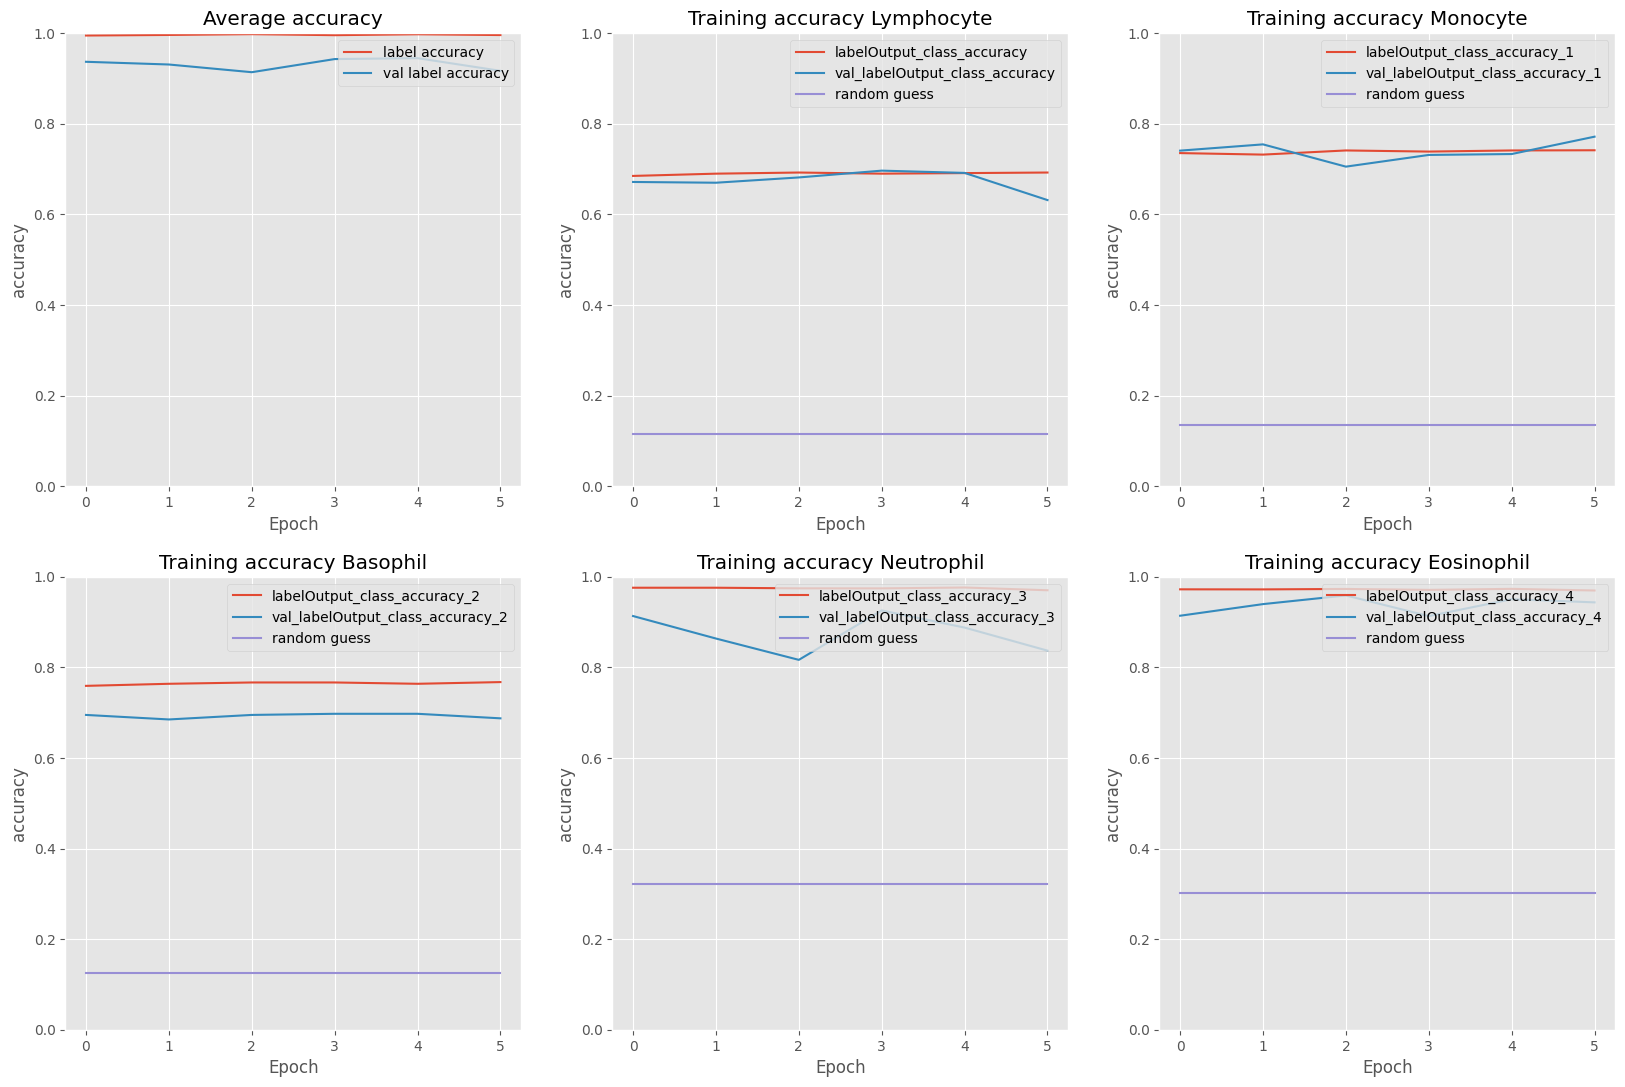

In [ ]:
# plot

plt.style.use("ggplot")
plt.figure(figsize=(20,20))
Nepoch=len(history.epoch)

outputType = 'label'
outputClassWeights = classWeightsRaw[outputType]

plt.subplot(3,3,1)
plt.plot(np.arange(0, Nepoch), history.history[f'{outputType}Output_accuracy'], label=f'{outputType} accuracy')

plt.plot(np.arange(0, Nepoch), history.history[f'val_{outputType}Output_accuracy'], label=f'val {outputType} accuracy')

plt.title(f"Average accuracy")
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend(loc="lower left")

i = 0
for key, weight in outputClassWeights.items():
	plt.subplot(3,3,i+2)
	index = '' if i == 0 else f'_{i}'
	trainKey = f'{outputType}Output_class_accuracy{index}'
	testKey = f'val_{trainKey}'
	
	plt.plot(np.arange(0, Nepoch), history.history[trainKey], label=trainKey)

	plt.plot(np.arange(0, Nepoch), history.history[testKey], label=testKey)
	plt.plot(np.arange(0, Nepoch), [weight for j in range(Nepoch)], label='random guess')		

	plt.title(f"Training accuracy {key}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")
	i += 1

plt.show()


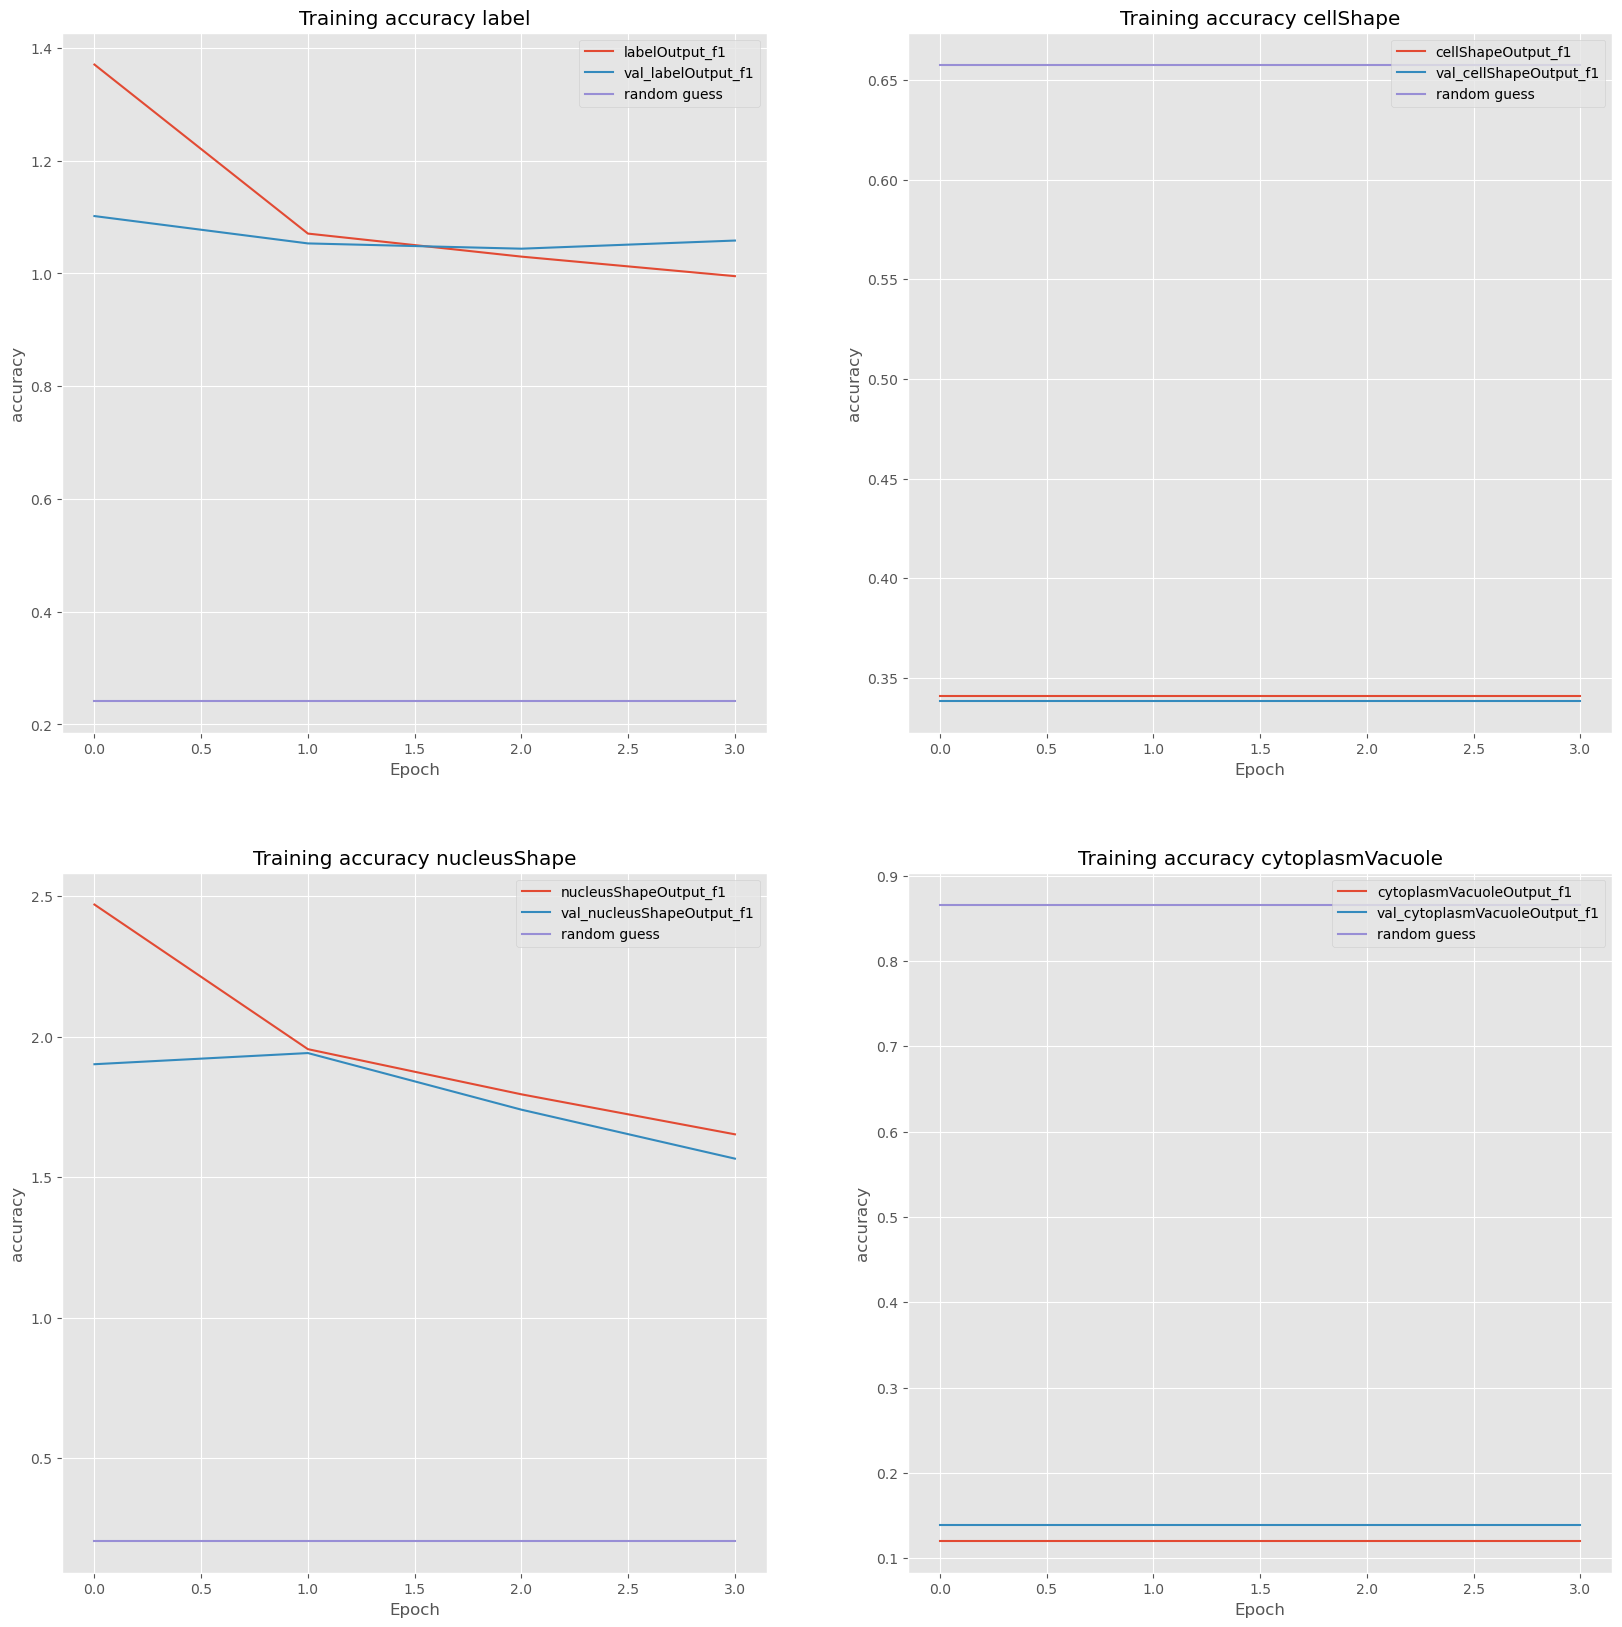

In [ ]:
# plot old

plt.style.use("ggplot")
plt.figure(figsize=(20,20))
Nepoch=len(history.epoch)

i = 0
for outLabel in ['label', 'cellShape', 'nucleusShape', 'cytoplasmVacuole']:
	i += 1
	plt.subplot(2,2,i)
	trainKey = f'{outLabel}Output_f1'
	testKey = f'val_{trainKey}'
	
	plt.plot(np.arange(0, Nepoch), history.history[trainKey], label=trainKey)

	plt.plot(np.arange(0, Nepoch), history.history[testKey], label=testKey)
	plt.plot(np.arange(0, Nepoch), [classRandomAcc[outLabel] for i in range(Nepoch)], label='random guess')		

	plt.title(f"Training accuracy {outLabel}")
	# plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left") 

plt.show()
